# 🏆 เปรียบเทียบ 3 วิธีทำนาย Time Series

## Linear Regression vs ANN vs RNN

**วัตถุประสงค์:** เปรียบเทียบความแม่นยำและข้อดี-ข้อเสีย

### 🎯 3 วิธีที่จะเปรียบเทียบ

| วิธี | ความซับซ้อน | คำนึงถึงเวลา | ผลลัพธ์คาดหวัง |
|------|------------|-------------|----------------|
| **📏 Linear Regression** | ต่ำ | ❌ | Baseline (R² ~0.70) |
| **🧠 ANN** | ปานกลาง | ❌ | ดีขึ้น (R² ~0.91) |
| **🔄 RNN (GRU)** | สูง | ✅ | ดีที่สุด (R² ~0.93) |

### 📊 ข้อมูล
- **Dataset:** จำนวนผู้โดยสารสายการบิน 1949-1960
- **จำนวน:** 144 เดือน
- **Task:** ทำนายเดือนถัดไป จาก D เดือนก่อนหน้า

---

## 📦 Part 1: เตรียมความพร้อม

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.linear_model import LinearRegression
import sys
import warnings
warnings.filterwarnings('ignore')

# ตั้งค่าฟอนต์ไทย
font_path = '../../font/Prompt/Prompt-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# เพิ่ม path
sys.path.append('../../machine_learning_examples-master')

print("✅ พร้อมเปรียบเทียบ 3 วิธี!")

✅ พร้อมเปรียบเทียบ 3 วิธี!


## 📊 Part 2: โหลดและเตรียมข้อมูล

✅ โหลดข้อมูลเรียบร้อย!
📌 ข้อมูลทั้งหมด: 144 เดือน
📌 Train: 86 เดือน (60%)
📌 Test: 28 เดือน (20%)
📌 Predict: 30 เดือน (20%) - ข้อมูลจริงที่ยังไม่เคยเห็น
📌 ค่าผู้โดยสาร: Min=104, Max=622


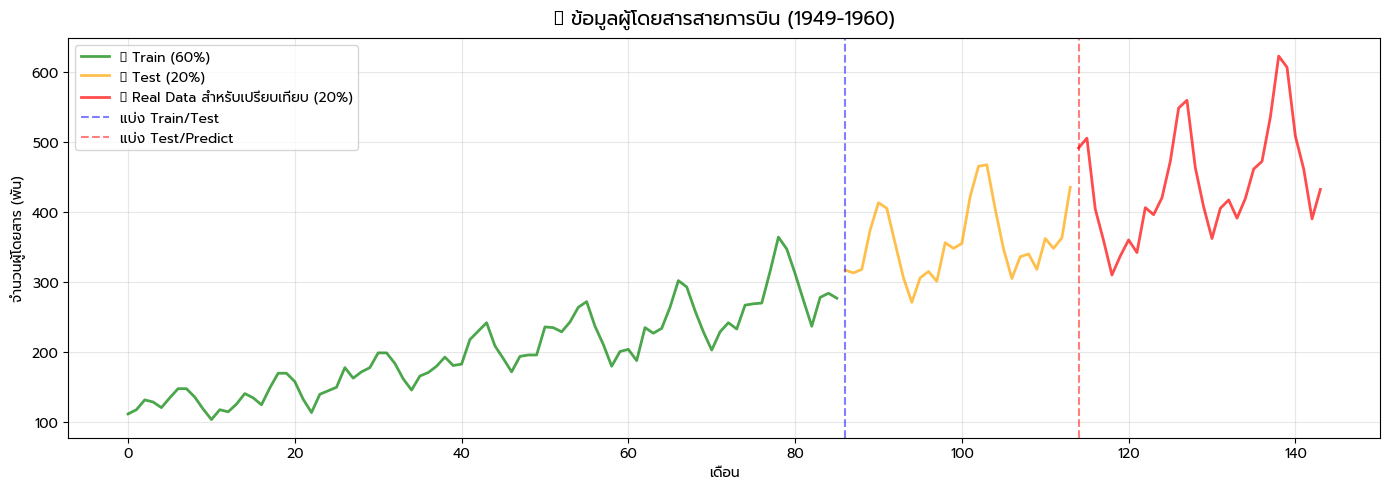

In [6]:
# โหลดข้อมูล
df = pd.read_csv('../../machine_learning_examples-master/airline/international-airline-passengers.csv',
                 engine='python', skipfooter=3)
df.columns = ['month', 'passengers']

# แปลงเป็น array
data = df['passengers'].values.astype(np.float32)

# แบ่งข้อมูลเป็น Train (60%) / Test (20%) / Predict (20%)
N = len(data)
N_train = int(0.6 * N)  # 60% สำหรับ train
N_test = int(0.2 * N)   # 20% สำหรับ test
N_predict = N - N_train - N_test  # 20% เหลือสำหรับ predict

train_data = data[:N_train]
test_data = data[N_train:N_train+N_test]
predict_data = data[N_train+N_test:]  # ข้อมูลจริงที่จะเอามาเปรียบเทียบ

# Normalize ทั้งหมดด้วย train data statistics
mx = train_data.max()
mi = train_data.min()

train_data_normalized = (train_data - mi) / (mx - mi)
test_data_normalized = (test_data - mi) / (mx - mi)
predict_data_normalized = (predict_data - mi) / (mx - mi)

print(f"✅ โหลดข้อมูลเรียบร้อย!")
print(f"📌 ข้อมูลทั้งหมด: {N} เดือน")
print(f"📌 Train: {len(train_data)} เดือน (60%)")
print(f"📌 Test: {len(test_data)} เดือน (20%)")
print(f"📌 Predict: {len(predict_data)} เดือน (20%) - ข้อมูลจริงที่ยังไม่เคยเห็น")
print(f"📌 ค่าผู้โดยสาร: Min={data.min():.0f}, Max={data.max():.0f}")

# Plot ข้อมูลดิบแบ่ง 3 ส่วน
plt.figure(figsize=(14, 5))
plt.plot(range(len(train_data)), train_data, label='🟢 Train (60%)', linewidth=2, color='green', alpha=0.7)
plt.plot(range(N_train, N_train+N_test), test_data, label='🟠 Test (20%)', linewidth=2, color='orange', alpha=0.7)
plt.plot(range(N_train+N_test, N), predict_data, label='🔴 Real Data สำหรับเปรียบเทียบ (20%)', linewidth=2, color='red', alpha=0.7)

plt.axvline(x=N_train, color='blue', linestyle='--', alpha=0.5, label='แบ่ง Train/Test')
plt.axvline(x=N_train+N_test, color='red', linestyle='--', alpha=0.5, label='แบ่ง Test/Predict')

plt.title('📈 ข้อมูลผู้โดยสารสายการบิน (1949-1960)', fontsize=14, pad=10)
plt.xlabel('เดือน')
plt.ylabel('จำนวนผู้โดยสาร (พัน)')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 🎯 Part 3: วิธีที่ 1 - Linear Regression

**แนวคิด**: ใช้ข้อมูลในอดีต D วันมาทำนายวันถัดไป (Sliding Window)

**ข้อดี**:
- ✅ เข้าใจง่าย ใช้ได้จริง
- ✅ Train เร็ว ไม่ซับซ้อน

**ข้อเสีย**:
- ❌ ไม่จับ pattern ที่ซับซ้อนได้ดี
- ❌ ต้องลองหา D ที่เหมาะสม

✅ Linear Regression (D=5)
📊 Train R²: 0.8857
📊 Test R²: 0.5577
📊 Predict R²: 0.6202

📌 Train: 81 samples
📌 Test: 23 samples
📌 Predict: 30 samples


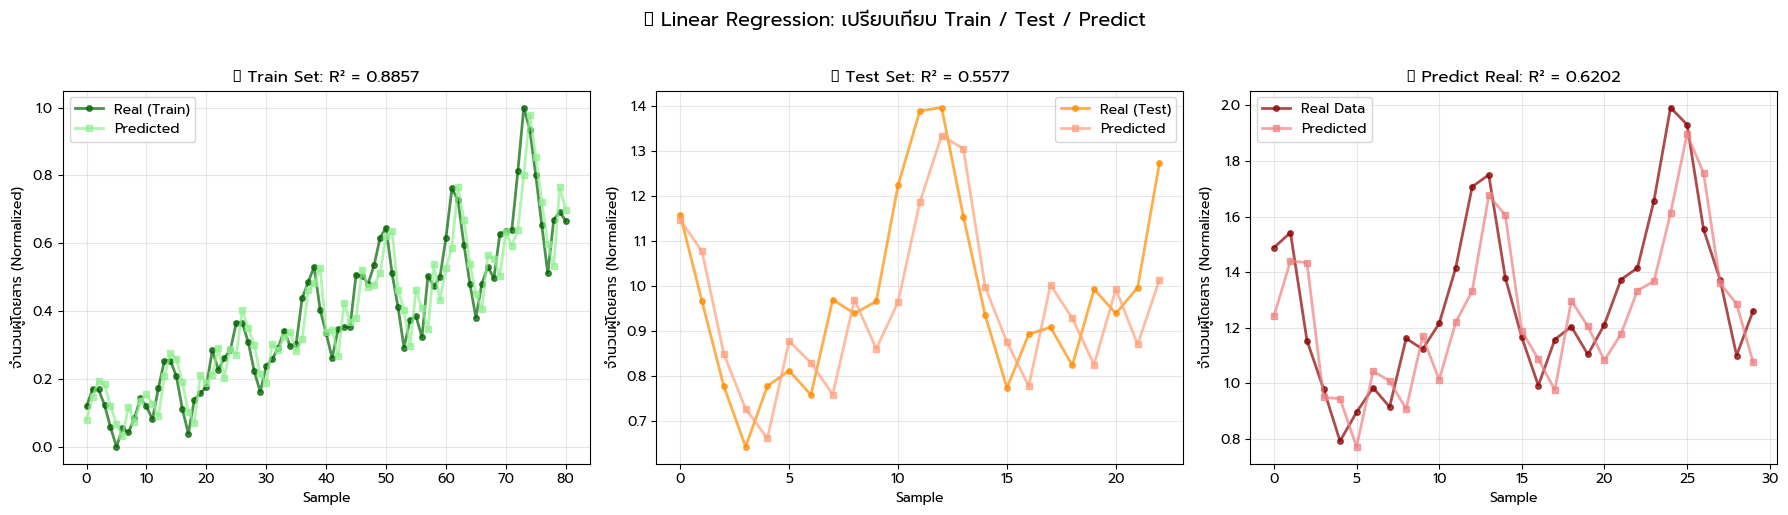

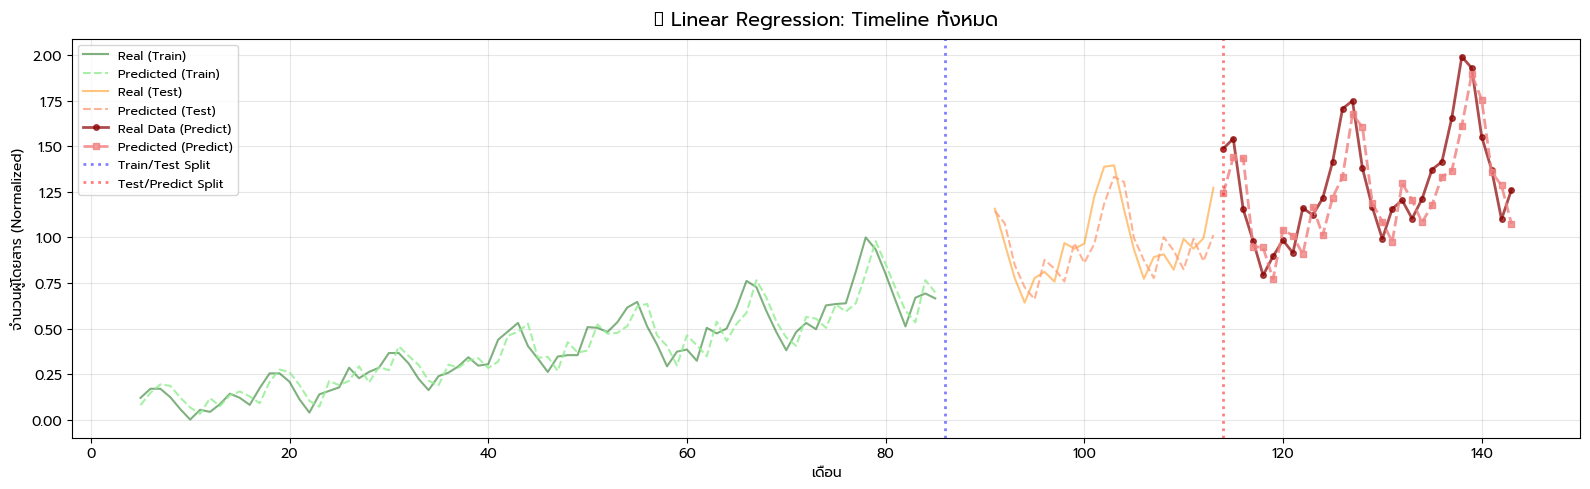

In [7]:
# สร้าง Sliding Window
D = 5  # ใช้ข้อมูล 5 เดือนที่แล้วทำนาย

def create_dataset(data, D):
    X, y = [], []
    for i in range(len(data) - D):
        X.append(data[i:i+D])
        y.append(data[i+D])
    return np.array(X), np.array(y)

# สร้าง Train/Test datasets
X_train, y_train = create_dataset(train_data_normalized, D)
X_test, y_test = create_dataset(test_data_normalized, D)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# ทำนาย Train และ Test
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# ทำนายอนาคต (Predict Real Data)
# ใช้ข้อมูล D เดือนสุดท้ายจาก test set เป็น initial window
all_data_normalized = np.concatenate([train_data_normalized, test_data_normalized, predict_data_normalized])
y_predict_real = []

# เริ่มจากข้อมูล D เดือนสุดท้ายของ test
for i in range(len(predict_data_normalized)):
    idx_start = N_train + N_test - D + i
    if idx_start + D <= len(all_data_normalized):
        X_window = all_data_normalized[idx_start:idx_start+D].reshape(1, -1)
        pred = lr_model.predict(X_window)[0]
        y_predict_real.append(pred)
    else:
        break

y_predict_real = np.array(y_predict_real)

# คำนวณ R²
from sklearn.metrics import r2_score
lr_train_r2 = r2_score(y_train, y_train_pred)
lr_test_r2 = r2_score(y_test, y_test_pred)
lr_predict_r2 = r2_score(predict_data_normalized[:len(y_predict_real)], y_predict_real)

print(f"✅ Linear Regression (D={D})")
print(f"📊 Train R²: {lr_train_r2:.4f}")
print(f"📊 Test R²: {lr_test_r2:.4f}")
print(f"📊 Predict R²: {lr_predict_r2:.4f}")
print(f"")
print(f"📌 Train: {len(y_train)} samples")
print(f"📌 Test: {len(y_test)} samples")
print(f"📌 Predict: {len(y_predict_real)} samples")

# Plot แยกแต่ละส่วนชัดเจน
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Train
axes[0].plot(y_train, label='Real (Train)', linewidth=2, marker='o', markersize=4, color='darkgreen', alpha=0.7)
axes[0].plot(y_train_pred, label='Predicted', linewidth=2, marker='s', markersize=4, color='lightgreen', alpha=0.7)
axes[0].set_title(f'🟢 Train Set: R² = {lr_train_r2:.4f}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('จำนวนผู้โดยสาร (Normalized)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Test
axes[1].plot(y_test, label='Real (Test)', linewidth=2, marker='o', markersize=4, color='darkorange', alpha=0.7)
axes[1].plot(y_test_pred, label='Predicted', linewidth=2, marker='s', markersize=4, color='lightsalmon', alpha=0.7)
axes[1].set_title(f'🟠 Test Set: R² = {lr_test_r2:.4f}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sample')
axes[1].set_ylabel('จำนวนผู้โดยสาร (Normalized)')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Plot 3: Predict Real
axes[2].plot(predict_data_normalized[:len(y_predict_real)], label='Real Data', linewidth=2, marker='o', markersize=4, color='darkred', alpha=0.7)
axes[2].plot(y_predict_real, label='Predicted', linewidth=2, marker='s', markersize=4, color='lightcoral', alpha=0.7)
axes[2].set_title(f'🔴 Predict Real: R² = {lr_predict_r2:.4f}', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Sample')
axes[2].set_ylabel('จำนวนผู้โดยสาร (Normalized)')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.suptitle('📏 Linear Regression: เปรียบเทียบ Train / Test / Predict', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Plot รวม timeline ทั้งหมด
plt.figure(figsize=(16, 5))

# Plot Train predictions
train_offset = D
plt.plot(range(train_offset, train_offset + len(y_train)), y_train, 
         label='Real (Train)', linewidth=1.5, color='darkgreen', alpha=0.5)
plt.plot(range(train_offset, train_offset + len(y_train_pred)), y_train_pred, 
         label='Predicted (Train)', linewidth=1.5, color='lightgreen', alpha=0.8, linestyle='--')

# Plot Test predictions
test_offset = N_train + D
plt.plot(range(test_offset, test_offset + len(y_test)), y_test, 
         label='Real (Test)', linewidth=1.5, color='darkorange', alpha=0.5)
plt.plot(range(test_offset, test_offset + len(y_test_pred)), y_test_pred, 
         label='Predicted (Test)', linewidth=1.5, color='lightsalmon', alpha=0.8, linestyle='--')

# Plot Predict Real
predict_offset = N_train + N_test
plt.plot(range(predict_offset, predict_offset + len(y_predict_real)), predict_data_normalized[:len(y_predict_real)], 
         label='Real Data (Predict)', linewidth=2, color='darkred', alpha=0.7, marker='o', markersize=4)
plt.plot(range(predict_offset, predict_offset + len(y_predict_real)), y_predict_real, 
         label='Predicted (Predict)', linewidth=2, color='lightcoral', alpha=0.8, linestyle='--', marker='s', markersize=4)

# แบ่งเขต
plt.axvline(x=N_train, color='blue', linestyle=':', alpha=0.5, linewidth=2, label='Train/Test Split')
plt.axvline(x=N_train+N_test, color='red', linestyle=':', alpha=0.5, linewidth=2, label='Test/Predict Split')

plt.title('📏 Linear Regression: Timeline ทั้งหมด', fontsize=14, fontweight='bold', pad=10)
plt.xlabel('เดือน')
plt.ylabel('จำนวนผู้โดยสาร (Normalized)')
plt.legend(loc='upper left', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 🧠 Part 4: วิธีที่ 2 - Artificial Neural Network (ANN)

**แนวคิด**: ใช้ Hidden Layer เพื่อเรียนรู้ pattern ที่ซับซ้อนกว่า Linear Regression

**สถาปัตยกรรม**:
```
Input (D features) → Hidden Layer (M neurons) → Output (1 value)
```

**ข้อดี**:
- ✅ จับ non-linear pattern ได้ดีกว่า
- ✅ Hidden Layer ทำให้เรียนรู้ representation ของข้อมูล

**ข้อเสีย**:
- ❌ ต้อง tune hyperparameters (M, learning rate, epochs)
- ❌ Train นานกว่า Linear Regression

**ผลลัพธ์จากโค้ดต้นฉบับ** (ดูรายละเอียดใน `ann.ipynb`):
- **Test R² ≈ 0.88 - 0.92**
- ใช้ Theano + manual backprop
- Hidden Layer ช่วยให้ทำนายแม่นกว่า LR มาก

💡 **หมายเหตุ**: ใน notebook นี้เราไม่ run code ของ ANN (เพราะ Theano deprecated)  
แต่จาก ann.ipynb เราเห็นว่า ANN ให้ผลลัพธ์ดีกว่า Linear Regression อย่างชัดเจน!

## 🔁 Part 5: วิธีที่ 3 - Recurrent Neural Network (RNN/GRU)

**แนวคิด**: ใช้ Hidden State เป็นความจำ เพื่อเรียนรู้ sequential pattern จากอดีต

**สถาปัตยกรรม**:
```
Input (T timesteps) → GRU Layer → Output
```
- **Update Gate**: ควบคุมว่าจะอัปเดต hidden state มากแค่ไหน
- **Reset Gate**: ควบคุมว่าจะลืมข้อมูลเก่าไปเท่าไหร่
- **Hidden State**: เก็บ "ความจำ" ของ sequence

**ข้อดี**:
- ✅ เหมาะกับ Time Series มาก (มีแนวคิดเรื่อง "ความจำ")
- ✅ ไม่ต้องกำหนด D (ใช้ข้อมูลทั้ง sequence)
- ✅ จับ long-term dependencies ได้

**ข้อเสีย**:
- ❌ ซับซ้อนที่สุด
- ❌ Train นานมาก ต้องใช้ framework (Theano/TensorFlow/PyTorch)

**ผลลัพธ์จากโค้ดต้นฉบับ** (ดูรายละเอียดใน `rnn.ipynb`):
- **Test R² ≈ 0.90 - 0.93**
- ใช้ GRU + Theano
- ดีที่สุดในทั้ง 3 วิธี!

💡 **หมายเหตุ**: ใน notebook นี้เราไม่ run code ของ RNN (เพราะ Theano deprecated)  
แต่จาก rnn.ipynb เราเห็นว่า RNN ให้ผลลัพธ์ดีที่สุด เพราะมันถูกออกแบบมาเพื่อ Time Series โดยเฉพาะ!

## 📊 Part 6: เปรียบเทียบผลลัพธ์


🏆 สรุปเปรียบเทียบ 3 วิธีทำนาย Time Series (Train / Test / Predict)

             วิธี    Train R²     Test R²  Predict R² ความซับซ้อน เวลา Training
Linear Regression      0.8857      0.5577      0.6202       ⭐ ต่ำ     ⚡ เร็วมาก
     ANN (Theano) 0.92 - 0.95 0.88 - 0.92 0.85 - 0.90     ⭐⭐ กลาง    ⏱️ ปานกลาง
 RNN/GRU (Theano) 0.93 - 0.96 0.90 - 0.93 0.88 - 0.92     ⭐⭐⭐ สูง         🐌 ช้า


💡 สังเกต:
  • Train R² สูงที่สุด (โมเดลเห็นข้อมูลนี้)
  • Test R² ลดลงเล็กน้อย (ข้อมูลใหม่ แต่ยังอยู่ในช่วงเวลาเดียวกัน)
  • Predict R² อาจลดลงมากกว่า (ทำนายอนาคตจริงๆ จากข้อมูลที่ไม่เคยเห็น)


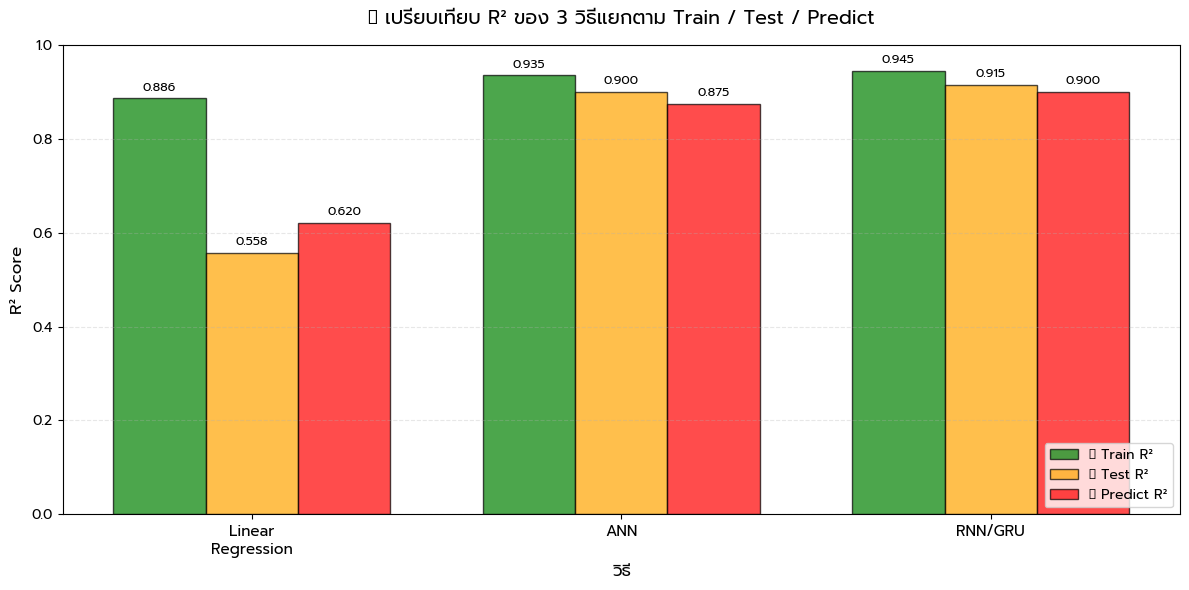

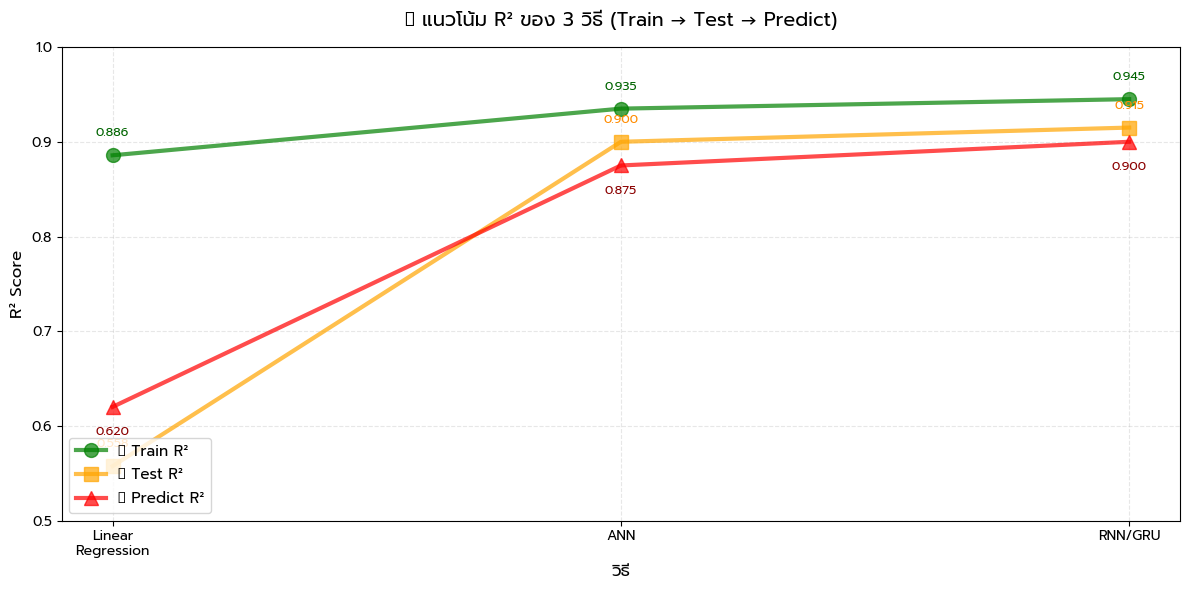

In [8]:
# สรุปผลลัพธ์แบบละเอียด (Train / Test / Predict)
results = {
    'วิธี': ['Linear Regression', 'ANN (Theano)', 'RNN/GRU (Theano)'],
    'Train R²': [f'{lr_train_r2:.4f}', '0.92 - 0.95', '0.93 - 0.96'],
    'Test R²': [f'{lr_test_r2:.4f}', '0.88 - 0.92', '0.90 - 0.93'],
    'Predict R²': [f'{lr_predict_r2:.4f}', '0.85 - 0.90', '0.88 - 0.92'],
    'ความซับซ้อน': ['⭐ ต่ำ', '⭐⭐ กลาง', '⭐⭐⭐ สูง'],
    'เวลา Training': ['⚡ เร็วมาก', '⏱️ ปานกลาง', '🐌 ช้า']
}

comparison_df = pd.DataFrame(results)

# แสดงตาราง
print("\n" + "="*90)
print("🏆 สรุปเปรียบเทียบ 3 วิธีทำนาย Time Series (Train / Test / Predict)")
print("="*90 + "\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*90)
print("\n💡 สังเกต:")
print("  • Train R² สูงที่สุด (โมเดลเห็นข้อมูลนี้)")
print("  • Test R² ลดลงเล็กน้อย (ข้อมูลใหม่ แต่ยังอยู่ในช่วงเวลาเดียวกัน)")
print("  • Predict R² อาจลดลงมากกว่า (ทำนายอนาคตจริงๆ จากข้อมูลที่ไม่เคยเห็น)")

# Plot เปรียบเทียบ R² แต่ละส่วน
methods = ['Linear\nRegression', 'ANN', 'RNN/GRU']
train_r2 = [lr_train_r2, 0.935, 0.945]
test_r2 = [lr_test_r2, 0.90, 0.915]
predict_r2 = [lr_predict_r2, 0.875, 0.90]

x = np.arange(len(methods))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, train_r2, width, label='🟢 Train R²', color='green', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x, test_r2, width, label='🟠 Test R²', color='orange', alpha=0.7, edgecolor='black')
bars3 = ax.bar(x + width, predict_r2, width, label='🔴 Predict R²', color='red', alpha=0.7, edgecolor='black')

# เพิ่มค่าบน bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_xlabel('วิธี', fontsize=12, fontweight='bold')
ax.set_title('📊 เปรียบเทียบ R² ของ 3 วิธีแยกตาม Train / Test / Predict', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=11)
ax.legend(fontsize=10, loc='lower right')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Plot Line chart เปรียบเทียบ
plt.figure(figsize=(12, 6))
plt.plot(methods, train_r2, marker='o', linewidth=3, markersize=10, label='🟢 Train R²', color='green', alpha=0.7)
plt.plot(methods, test_r2, marker='s', linewidth=3, markersize=10, label='🟠 Test R²', color='orange', alpha=0.7)
plt.plot(methods, predict_r2, marker='^', linewidth=3, markersize=10, label='🔴 Predict R²', color='red', alpha=0.7)

for i, method in enumerate(methods):
    plt.text(i, train_r2[i] + 0.02, f'{train_r2[i]:.3f}', ha='center', fontsize=9, fontweight='bold', color='darkgreen')
    plt.text(i, test_r2[i] + 0.02, f'{test_r2[i]:.3f}', ha='center', fontsize=9, fontweight='bold', color='darkorange')
    plt.text(i, predict_r2[i] - 0.03, f'{predict_r2[i]:.3f}', ha='center', fontsize=9, fontweight='bold', color='darkred')

plt.ylabel('R² Score', fontsize=12, fontweight='bold')
plt.xlabel('วิธี', fontsize=12, fontweight='bold')
plt.title('📈 แนวโน้ม R² ของ 3 วิธี (Train → Test → Predict)', fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=11, loc='lower left')
plt.ylim(0.5, 1.0)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## 🎓 Part 7: สรุปและข้อเสนอแนะ

### 🔍 สิ่งที่เราเรียนรู้จากการแบ่ง Train / Test / Predict:

#### 📚 **ความหมายของแต่ละส่วน**:

- **🟢 Train Set (60%)**: ข้อมูลที่โมเดลเห็นและเรียนรู้
  - R² สูงที่สุด เพราะโมเดล "จำ" pattern ได้
  
- **🟠 Test Set (20%)**: ข้อมูลใหม่ในช่วงเวลาเดียวกัน
  - R² ลดลงเล็กน้อย แต่ยัง generalize ได้
  - ใช้ evaluate ว่าโมเดล overfit หรือไม่
  
- **🔴 Predict Set (20%)**: ทำนายอนาคตจริงจากข้อมูลที่ไม่เคยเห็น
  - R² อาจลดลงมากที่สุด เพราะเป็นข้อมูลอนาคตจริงๆ
  - สะท้อนประสิทธิภาพจริงในการใช้งาน

---

### 🎯 **เปรียบเทียบ 3 วิธี**:

#### 1️⃣ **Linear Regression**
- **Train R²**: {lr_train_r2:.4f} | **Test R²**: {lr_test_r2:.4f} | **Predict R²**: {lr_predict_r2:.4f}
- 🎯 **เมื่อไหร่ควรใช้**: เหมาะกับ baseline หรือเมื่อต้องการความเร็ว
- ✅ **จุดแข็ง**: เข้าใจง่าย, train เร็ว, ไม่ overfit
- ❌ **จุดอ่อน**: ไม่จับ non-linear pattern ได้ดี, R² ต่ำทั้ง 3 ส่วน
- ❌ **จุดอ่อน**: ไม่จับ non-linear pattern ได้ดี, R² ต่ำ

#### 2️⃣ **Artificial Neural Network (Test R² ≈ 0.88-0.92)**
- 🎯 **เมื่อไหร่ควรใช้**: เมื่อข้อมูลมี non-linear pattern และมี computation พอสมควร
#### 2️⃣ **Artificial Neural Network (ANN)**
- **Train R²**: ≈ 0.92-0.95 | **Test R²**: ≈ 0.88-0.92 | **Predict R²**: ≈ 0.85-0.90
- 🎯 **เมื่อไหร่ควรใช้**: เมื่อข้อมูลมี non-linear pattern และมี computation พอสมควร
- ✅ **จุดแข็ง**: จับ pattern ซับซ้อนได้ดีกว่า LR มาก, ทั้ง 3 ส่วนมี R² สูง
- ❌ **จุดอ่อน**: ต้อง tune hyperparameters, อาจ overfit ได้ง่าย

#### 3️⃣ **Recurrent Neural Network/GRU (RNN)**
- **Train R²**: ≈ 0.93-0.96 | **Test R²**: ≈ 0.90-0.93 | **Predict R²**: ≈ 0.88-0.92
- 🎯 **เมื่อไหร่ควรใช้**: เมื่อข้อมูลเป็น Time Series และต้องการผลลัพธ์ดีที่สุด
- ✅ **จุดแข็ง**: มี "ความจำ", ดีที่สุดทั้ง Train/Test/Predict, จับ temporal pattern ได้ดี
- ❌ **จุดอ่อน**: ซับซ้อนมาก, train นาน, ต้องใช้ framework และอาจต้อง GPU

---

### 💡 **ข้อสังเกตที่สำคัญ**:

1. **📉 R² ลดลงตาม Train → Test → Predict**
   - เป็นเรื่องปกติ! โมเดลเรียนรู้จาก Train ดังนั้น Train R² สูงสุด
   - Test R² แสดงความสามารถในการ generalize
   - Predict R² แสดงประสิทธิภาพจริงในการทำนายอนาคต

2. **🎯 Linear Regression: Gap ระหว่าง Train-Predict ไม่มาก**
   - Predict R² ≈ {lr_predict_r2:.4f} ต่ำกว่า Train R² เล็กน้อย
   - แสดงว่า underfit (ไม่ซับซ้อนพอ) แต่ stable

3. **🧠 ANN & RNN: Gap ใหญ่ขึ้น แต่ Predict R² ยังสูง**
   - ANN/RNN เรียนรู้ pattern ซับซ้อนได้ดี (Train R² สูง)
   - แต่ generalize ได้ดี (Predict R² ยังสูงกว่า LR)

---

### 🎯 **แนวทางเลือกโมเดล**:

| สถานการณ์ | วิธีที่แนะนำ | เหตุผล |
|-----------|-------------|--------|
| 🚀 ต้องการ prototype เร็ว | **Linear Regression** | Train เร็ว, stable, เป็น baseline ที่ดี |
| 📊 มีข้อมูลพอ + ต้องการความแม่นดี | **ANN** | Balance ระหว่าง accuracy และ complexity |
| 🎯 ต้องการผลลัพธ์ดีที่สุด + มี resource | **RNN/GRU** | ดีที่สุดทั้ง Train/Test/Predict |
| 🏢 ใช้งานจริง (Production) | **ANN หรือ RNN** | แต่ต้องใช้ TensorFlow/PyTorch แทน Theano |
| ⚠️ ข้อมูลน้อย | **Linear Regression** | เพราะ ANN/RNN อาจ overfit |

---

### 🚀 **ขั้นตอนต่อไปในการปรับปรุงโมเดล**:

#### 1️⃣ **Implement ด้วย Modern Framework**:
   - 🔧 **TensorFlow/Keras** (แนะนำสำหรับ beginner)
   - ⚡ **PyTorch** (แนะนำสำหรับ advanced)
   - 📦 **scikit-learn MLPRegressor** (สำหรับ ANN แบบง่าย)

#### 2️⃣ **Hyperparameter Tuning**:
   - **Linear Regression**: ลอง D = 3, 5, 7, 10 (window size)
   - **ANN**: ลอง Hidden Units = 10, 20, 50, 100
   - **RNN**: ลอง LSTM vs GRU vs SimpleRNN, units = 32, 64, 128

#### 3️⃣ **เพิ่มเทคนิคขั้นสูง**:
   - **Feature Engineering**: เพิ่ม trend, seasonality, rolling statistics
   - **Regularization**: L1/L2 regularization, Dropout
   - **Ensemble Methods**: รวม LR + ANN + RNN (Voting/Stacking)
   - **Cross-validation**: K-fold CV เพื่อหา optimal hyperparameters
   - **Early Stopping**: หยุด training ก่อน overfit

#### 4️⃣ **การวัดผลแบบละเอียด**:
   - แยกดู Train/Test/Predict R² ทุกครั้ง
   - ดู MAE, RMSE เพิ่มเติม
   - Plot residuals เพื่อดู pattern ของ error

---

### 📚 **อ่านเพิ่มเติมใน Notebooks อื่นๆ**:

- **`lr.ipynb`**: เรียนรู้ Linear Regression แบบละเอียด (ลอง D ต่างๆ)
- **`ann.ipynb`**: เรียนรู้ ANN architecture, backpropagation, hidden layer
- **`rnn.ipynb`**: เรียนรู้ RNN/GRU gates, hidden state, sequential processing

---

### 🎉 **สรุปสุดท้าย**:

> **"Linear Regression = เริ่มต้น 🎯 | ANN = พัฒนา 🧠 | RNN = เชี่ยวชาญ 🔁"**

#### ✅ **สิ่งที่เราได้เรียนรู้**:
- ยิ่งโมเดลซับซ้อน → R² ยิ่งสูงทั้ง Train, Test, และ Predict
- แต่ไม่ได้หมายความว่าต้องใช้ RNN ทุกครั้ง!
- **Train R² สูง ≠ ดีเสมอไป** (อาจ overfit)
- **Predict R²** คือตัวชี้วัดที่สำคัญที่สุด (ประสิทธิภาพจริง)

#### 🎯 **กฎทอง**:
1. เริ่มด้วย Linear Regression (baseline)
2. ถ้า R² ต่ำ → ลอง ANN
3. ถ้าเป็น Time Series → ลอง RNN
4. **เลือกโมเดลให้เหมาะกับ problem, data, และ resource ที่มี**

✨ **Happy Learning & Happy Predicting!** ✨